<a href="https://colab.research.google.com/github/mydevfair/data-driven-ai/blob/main/Coursework1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Booking Cancallation Prediction

**Load Data**

Load Hotel_Booking/hotel_bookings.csv file provided on Brightspace.

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [169]:
df = pd.read_csv('/content/drive/MyDrive/hotel_bookings.csv')

In [170]:
# Check dataset shape
print("Dataset shape:", df.shape)

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Display column names
print("\nColumn names:")
print(df.columns.tolist())

# Display data types and missing values
print("\nDataset info:")
df.info()

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (119390, 32)

First 5 rows:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                

# 1. Data Pre-processing (25%)


---






**Drop irrelevant columns**

It will significantly reduce the time and effort you need to invest. As a general guideline, columns containing IDs, dates, or irrelevant information are typically considered redundant and offer little value for predictive analysis.

In [171]:
# Drop irrelevant columns
columns_to_drop = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
                   'arrival_date_day_of_month', 'reservation_status_date', 'reservation_status']
df.drop(columns_to_drop, axis=1, inplace=True)

# Check the shape after dropping
print(df.shape)

# List columns one by one
for col in df.columns:
    print(col)

(119390, 26)
hotel
is_canceled
lead_time
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
meal
country
market_segment
distribution_channel
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
reserved_room_type
assigned_room_type
booking_changes
deposit_type
agent
company
days_in_waiting_list
customer_type
adr
required_car_parking_spaces
total_of_special_requests


Dropped date-related columns as they are not useful for prediction.
Dropped reservation_status as it directly reveals whether booking was canceled, which is our target variable.
This reduces redundancy and prevents data leakage.

## Unique values

Find out unique values in columns. This will help you in identifying in-consistent data.

In [172]:
# Check unique values for each column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

hotel: 2 unique values
is_canceled: 2 unique values
lead_time: 479 unique values
stays_in_weekend_nights: 17 unique values
stays_in_week_nights: 35 unique values
adults: 14 unique values
children: 5 unique values
babies: 5 unique values
meal: 5 unique values
country: 177 unique values
market_segment: 8 unique values
distribution_channel: 5 unique values
is_repeated_guest: 2 unique values
previous_cancellations: 15 unique values
previous_bookings_not_canceled: 73 unique values
reserved_room_type: 10 unique values
assigned_room_type: 12 unique values
booking_changes: 21 unique values
deposit_type: 3 unique values
agent: 333 unique values
company: 352 unique values
days_in_waiting_list: 128 unique values
customer_type: 4 unique values
adr: 8879 unique values
required_car_parking_spaces: 5 unique values
total_of_special_requests: 6 unique values


## 1.1 Missing Values (10%)

Identify and handle missing values.

In [173]:
# Check missing values
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_par

In [174]:
# Drop 'company' and 'agent' columns - too many missing values
df.drop(['company', 'agent'], axis=1, inplace=True)

# Fill 'children' with 0 (assume no children if missing)
df['children'] = df['children'].fillna(0)

# Fill 'country' with 'Unknown' (categorical column)
df['country'] = df['country'].fillna('Unknown')

# Verify no missing values remain
print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64


Dropped 'company' and 'agent' columns due to high percentage of missing values.
Filled 'children' with 0 assuming no children when not specified.
Filled 'country' with 'Unknown' to retain rows while handling missing categorical data.

## 1.2 Removing Inconsistent values and Outliers (10%)

Detecting inconsistencies can be achieved through a variety of methods. Some can be identified by examining unique values within each column, while others may require a solid understanding of the problem domain. Since you might not be an expert in the hotel or hospitality industry, here are some helpful hints:

Hints:

1. Check for incomplete bookings, such as reservations with zero adults, babies, or children.
2. Examine rows with zeros in both 'stays_in_weekend_nights' and 'stays_in_week_nights.'



In [175]:
# Check for bookings with zero guests (no adults, children, or babies)
zero_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]
print(f"Bookings with zero guests: {len(zero_guests)}")

# Check for bookings with zero nights stay
zero_nights = df[(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] == 0)]
print(f"Bookings with zero nights: {len(zero_nights)}")

Bookings with zero guests: 180
Bookings with zero nights: 715


In [176]:
# Remove bookings with zero guests
df = df.drop(df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)].index)

# Remove bookings with zero nights stay
df = df.drop(df[(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] == 0)].index)

# Check shape after removing inconsistent data
print(df.shape)

(118565, 24)


Removed bookings with zero guests as these are incomplete/invalid reservations.
Removed bookings with zero nights stay as these do not represent actual hotel stays.

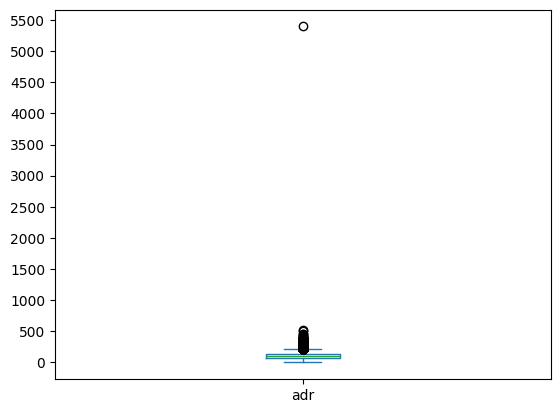

count    118565.000000
mean        102.523809
std          50.005542
min          -6.380000
25%          70.000000
50%          95.000000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64
Maximum ADR: 5400.0
Minimum ADR: -6.38
ADR above 1000: 1
Negative ADR: 1


In [177]:
df.plot(y='adr', kind='box')
plt.yticks(range(0, 6000, 500))
plt.show()

# Check ADR statistics
print(df['adr'].describe())
print(f"Maximum ADR: {df['adr'].max()}")
print(f"Minimum ADR: {df['adr'].min()}")

# Count extreme values
print(f"ADR above 1000: {len(df[df['adr'] > 1000])}")
print(f"Negative ADR: {len(df[df['adr'] < 0])}")

In [178]:
# Remove negative and extremely high ADR values
df = df[df['adr'] >= 0]
df = df[df['adr'] < 1000]

print(df.shape)

(118563, 24)


Removed negative ADR values and extreme outliers above 1000.

Removed negative ADR values and extreme outliers above 1000.

## 1.3 Column data type conversion (5%)

All necessary columns should be correctly converted to appropriate data types.


In [179]:
# <<< Your code here >>>

# 2. Exploratory Data Analysis (25%)


---





You've also been provided with examples of valuable insights that could be of interest to hotel management, including:

* Calculating cancellation percentages for City and Resort hotels.
* Identifying the most frequently ordered meal types.
* Determining the number of returning guests.
* Discovering the most booked room types.
* Exploring correlations between room types and cancellations.


For each of these tasks, choose a suitable type of visualisation covered in
the practical sessions, such as:

* Bar graphs
* Pie charts
* Line charts
* Heatmaps

## 2.1. Calculating cancellation percentages for City and Resort hotels.

In [180]:
# <<< Your code here >>>

## 2.2. Identifying the most frequently ordered meal types.

In [181]:
# <<< Your code here >>>

## 2.3. Determining the number of returning guests.

In [182]:
# <<< Your code here >>>

## 2.4. Discovering the most booked room types.

In [183]:
# <<< Your code here >>>

## 2.5. Exploring correlations between room types and cancellations.

In [184]:
# <<< Your code here >>>

# 3. Feature Engineering (20%)


---





Apply various feature engineering techniques, covered in the lectures and practicals.

Hint:
* Binning
* Encoding
* Scaling
* Feature selection

In [185]:
# <<< Your code here >>>

# 4. Classifier Training (20%)


---


Utilise the sklearn Python library to train a ML model (e.g.decision tree classifier). Your process should start with splitting your dataset into input features (X) and a target feature (y). Next, divide the data into 70% training and 30% testing subsets. Train your model on the training dataset and evaluate using test dataset with appropriate metrics. Aim to achieve higher accuracy e.g. more than 70% accuracy using your model.

## 4.1. Data Splitting (5%)

In [186]:
# <<< Your code here >>>

## 4.2. Model Training (10%)

In [187]:
# <<< Your code here >>>

## 4.3. Model Evaluation (5%)

In [188]:
# <<< Your code here >>>

# 5. Feature Importance (10%)


---

Assess the importance of features within your decision tree model. Provide commentary on the reliability of your model's results based on the feature importance scores.

In [189]:
# <<< Your code here >>>